In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from pysindy import SINDy
from sklearn.preprocessing import StandardScaler
from pysindy.optimizers import STLSQ
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import StratifiedKFold 
from pysindy.feature_library import PolynomialLibrary, FourierLibrary, GeneralizedLibrary

In [140]:
df = pd.read_csv("processed_well_data.csv")

In [141]:
print(df.isnull().sum())

Well no                    0
Dia                        0
Dev(deg)                   0
LiquidFlowrate             0
Gasflowrate                0
Area (m2)                  0
z                          0
GasDens                    0
Condesnate Presence        0
Water presence             0
LiquidDens                 0
GasVis                     0
LiqVis                     0
g (m/s2)                   0
Test Vg                    0
P/T                        0
Test status                0
Vsg                        0
Vsl                        0
Rel                        0
Reg                        0
film thickness             0
d(0,90)                    0
d(15,90)                   0
d(30,90)                   0
d(45,90)                   0
d(60,90)                   0
d(90,90)                   0
d(120,90)                  0
d(150,90)                  0
d(180,90)                  0
d(210,90)                  0
d(270,90)                  0
d(360,90)                  0
friction_facto

# Data preparation 

In [142]:
# Split features
X = df[['Dia', 'Dev(deg)','Area (m2)', 'z','GasDens','LiquidDens', 'P/T','friction_factor', 'critical_film_thickness']]
y = df['Qcr']
gsflow = df['Gasflowrate']  # This is your additional target for classification metrics

# load class labels: loaded/unloaded/near loaded
loading_class = df['Test status'].apply(
    lambda x: -1 if x == 'Unloaded' else (0 if x == 'Near L.U' else 1)).to_numpy()

# Perform the train-test split, making sure to split all targets simultaneously
X_train, X_test, y_train, y_test, gsflow_train, gsflow_test, loading_train, loading_test = train_test_split(
    X, y, gsflow, loading_class, test_size=0.20, random_state=42, stratify=loading_class
)

"""
For final evaluation of the model, we need designate test data and normalize to all training data
"""
# Scale your features and continuous target (Qcr)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
X_scaled = scaler_X.transform(X)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))
y_scaled = scaler_y.transform(y.values.reshape(-1, 1))

# t_train is just an index array for plotting
t_train = np.arange(len(y_train_scaled))
t = np.arange(len(y_scaled))

#convert to a numpy array and store test data 
loading_train = np.array(loading_train)
loading_test = np.array(loading_test)
loading = np.array(loading_class)
gsflow_test = np.array(gsflow_test)
gsflow = np.array(gsflow)
y_test = np.array(y_test)
y = np.array(y)

In [143]:
# accuracy metric and confusion matrix 
def calculate_accuracy(y_pred, gsflow, loading_actual, interval):
    loading_pred = np.where(y_pred > gsflow + interval, 1, 
                          np.where(y_pred < gsflow - interval, -1, 0))
    return accuracy_score(loading_actual, loading_pred), confusion_matrix(loading_actual, loading_pred,  labels=[-1, 0, 1])

In [144]:
# K-fold cross validation

def evaluate_sindy(params, X, y, gsflow, loading_class, cv_splits=5):
    alpha, threshold, interval, n = params
    
    # Use StratifiedKFold to preserve class balance in splits
    kf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    acc_scores = []
    
    for train_idx, val_idx in kf.split(X, loading_class):  # Using validation split from training data
        # divide into trianing/validation sets
        X_train_cv, X_val_cv = X[train_idx], X[val_idx]
        y_train_cv, y_val_cv = y[train_idx], y[val_idx]
        gsflow_val_cv = gsflow[val_idx]
        loading_val_cv = loading_class[val_idx]
        
        scaler_X = StandardScaler()
        X_train_cv_scaled = scaler_X.fit_transform(X_train_cv)
        X_val_cv_scaled = scaler_X.transform(X_val_cv)
        
        scaler_y = StandardScaler()
        y_train_cv_scaled = scaler_y.fit_transform(y_train_cv.reshape(-1, 1))
        
        # Define optimizer for SINDy
        optimizer = STLSQ(
            alpha=alpha,
            threshold=threshold,
            max_iter=10000,
            normalize_columns=True
        )
        
        # Train model
        model = SINDy(optimizer=optimizer, feature_library=PolynomialLibrary(degree=int(n)) )
        model.fit(X_train_cv_scaled, t=np.arange(len(y_train_cv_scaled)), 
                 x_dot=y_train_cv_scaled)
        
        # Compute performance on validation set 
        y_val_pred_scaled = model.predict(X_val_cv_scaled)
        y_val_pred_cv = scaler_y.inverse_transform(y_val_pred_scaled).flatten()
        
        acc, cm = calculate_accuracy(y_val_pred_cv, gsflow_val_cv, loading_val_cv, interval)
        acc_scores.append(acc)
    
    return np.mean(acc_scores)


In [145]:

def optimize_sindy_hyperparameters(X_train, y_train, gsflow_train, loading_train, param_grid):
    best_score = -1
    best_params = None
    
    X_train = np.array(X_train)
    y_train = np.array(y_train).flatten()
    gsflow_train = np.array(gsflow_train)
    loading_train = np.array(loading_train)
    
    print("Begin training and hyperparameter optimization...")
    for alpha in param_grid['alpha']:
        for threshold in param_grid['threshold']:
            for interval in param_grid['interval']:
                for n in param_grid['n']:
                    score = evaluate_sindy((alpha, threshold, interval, n), 
                                        X_train, y_train, gsflow_train, loading_train)
                    
                    if score > best_score:
                        best_score = score
                        best_params = {'alpha': alpha, 'threshold': threshold, 'interval': interval, 'n': n}
    
    return best_params, best_score

In [146]:
# Grid search for optimal hyperparameters 
param_grid = {
    'alpha': np.logspace(-4, 0.25, 10),      
    'threshold': np.logspace(-4, -1, 10),  
    'interval': np.linspace(0, 10, 10) , 
    'n': np.array([1, 2, 3, 4, 5])
}

#  Train model and optimize hyperparameters 
best_params, best_score = optimize_sindy_hyperparameters(
    X_train, y_train, gsflow_train, loading_train, param_grid
)

print("\nBest parameters found:")
print(best_params)
print(f"Best CV accuracy: {best_score*100:.2f}%")

# Train final model on FULL training set with best params and evaluate on the final test set
final_optimizer = STLSQ(
    alpha=best_params['alpha'],
    threshold=best_params['threshold'],
    max_iter=10000,
    normalize_columns=True
)

# Evaluate model performance 
final_model = SINDy(optimizer=final_optimizer, feature_library=PolynomialLibrary(degree=int(best_params['n'])))
final_model.fit(X_train_scaled, t=t_train, x_dot=y_train_scaled)

# Evaluate on trainin set
y_pred_train_scaled = final_model.predict(X_train_scaled)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled).flatten()

# Evaluate on TEST set (previously unseen data)
y_pred_test_scaled = final_model.predict(X_test_scaled)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled).flatten()

# Calculate metrics on TEST set
train_acc, train_cm = calculate_accuracy(y_pred_train, gsflow_train, loading_train, best_params['interval'])
test_acc, test_cm = calculate_accuracy(y_pred_test, gsflow_test, loading_test, best_params['interval'])

print("\n=== Final Model Performance ===")
final_model.print()
print(f"\nTraining Set Classification Accuracy: {train_acc*100:.2f}%")
print(f"Test Set Classification Accuracy: {test_acc*100:.2f}%")

print("Confusion Matrix for Train Set Classification")
print(train_cm)
print("Confusion Matrix for Test Set Classification")
print(test_cm)

Begin training and hyperparameter optimization...

Best parameters found:
{'alpha': 0.5994842503189409, 'threshold': 0.1, 'interval': 0.0, 'n': 2}
Best CV accuracy: 71.05%

=== Final Model Performance ===
(x0)' = 1350975005576.519 1 + -9.480 x0 + -1560363692559.453 x1 + 2.482 x2 + 5.860 x3 + 4.276 x4 + -1409364242017.377 x5 + 1.472 x6 + -14.600 x7 + 11.386 x8 + -0.249 x0^2 + 1.506 x0 x1 + -0.593 x0 x2 + 0.054 x0 x3 + -0.038 x0 x4 + -0.220 x0 x5 + -7.762 x0 x7 + -0.372 x0 x8 + 0.695 x1^2 + -3.816 x1 x2 + -5.387 x1 x3 + -0.405 x1 x4 + 1627802723038.100 x1 x5 + -0.635 x1 x6 + -0.272 x1 x8 + 1.592 x2^2 + -0.132 x2 x3 + 0.396 x2 x4 + -0.512 x2 x5 + 1.329 x2 x6 + 3.422 x2 x7 + -0.548 x2 x8 + 0.064 x3^2 + -0.423 x3 x4 + 1.377 x3 x5 + 0.542 x3 x6 + -0.322 x3 x8 + -1.412 x4 x5 + -0.888 x4 x6 + 4.053 x4 x7 + 2.380 x4 x8 + 0.680 x5^2 + -0.479 x5 x6 + -0.731 x5 x7 + -0.149 x5 x8 + 2.216 x6 x7 + -1.427 x6 x8 + 0.474 x7^2 + -0.666 x7 x8 + 0.057 x8^2

Training Set Classification Accuracy: 75.90%
Test

# Classification graph for well status 

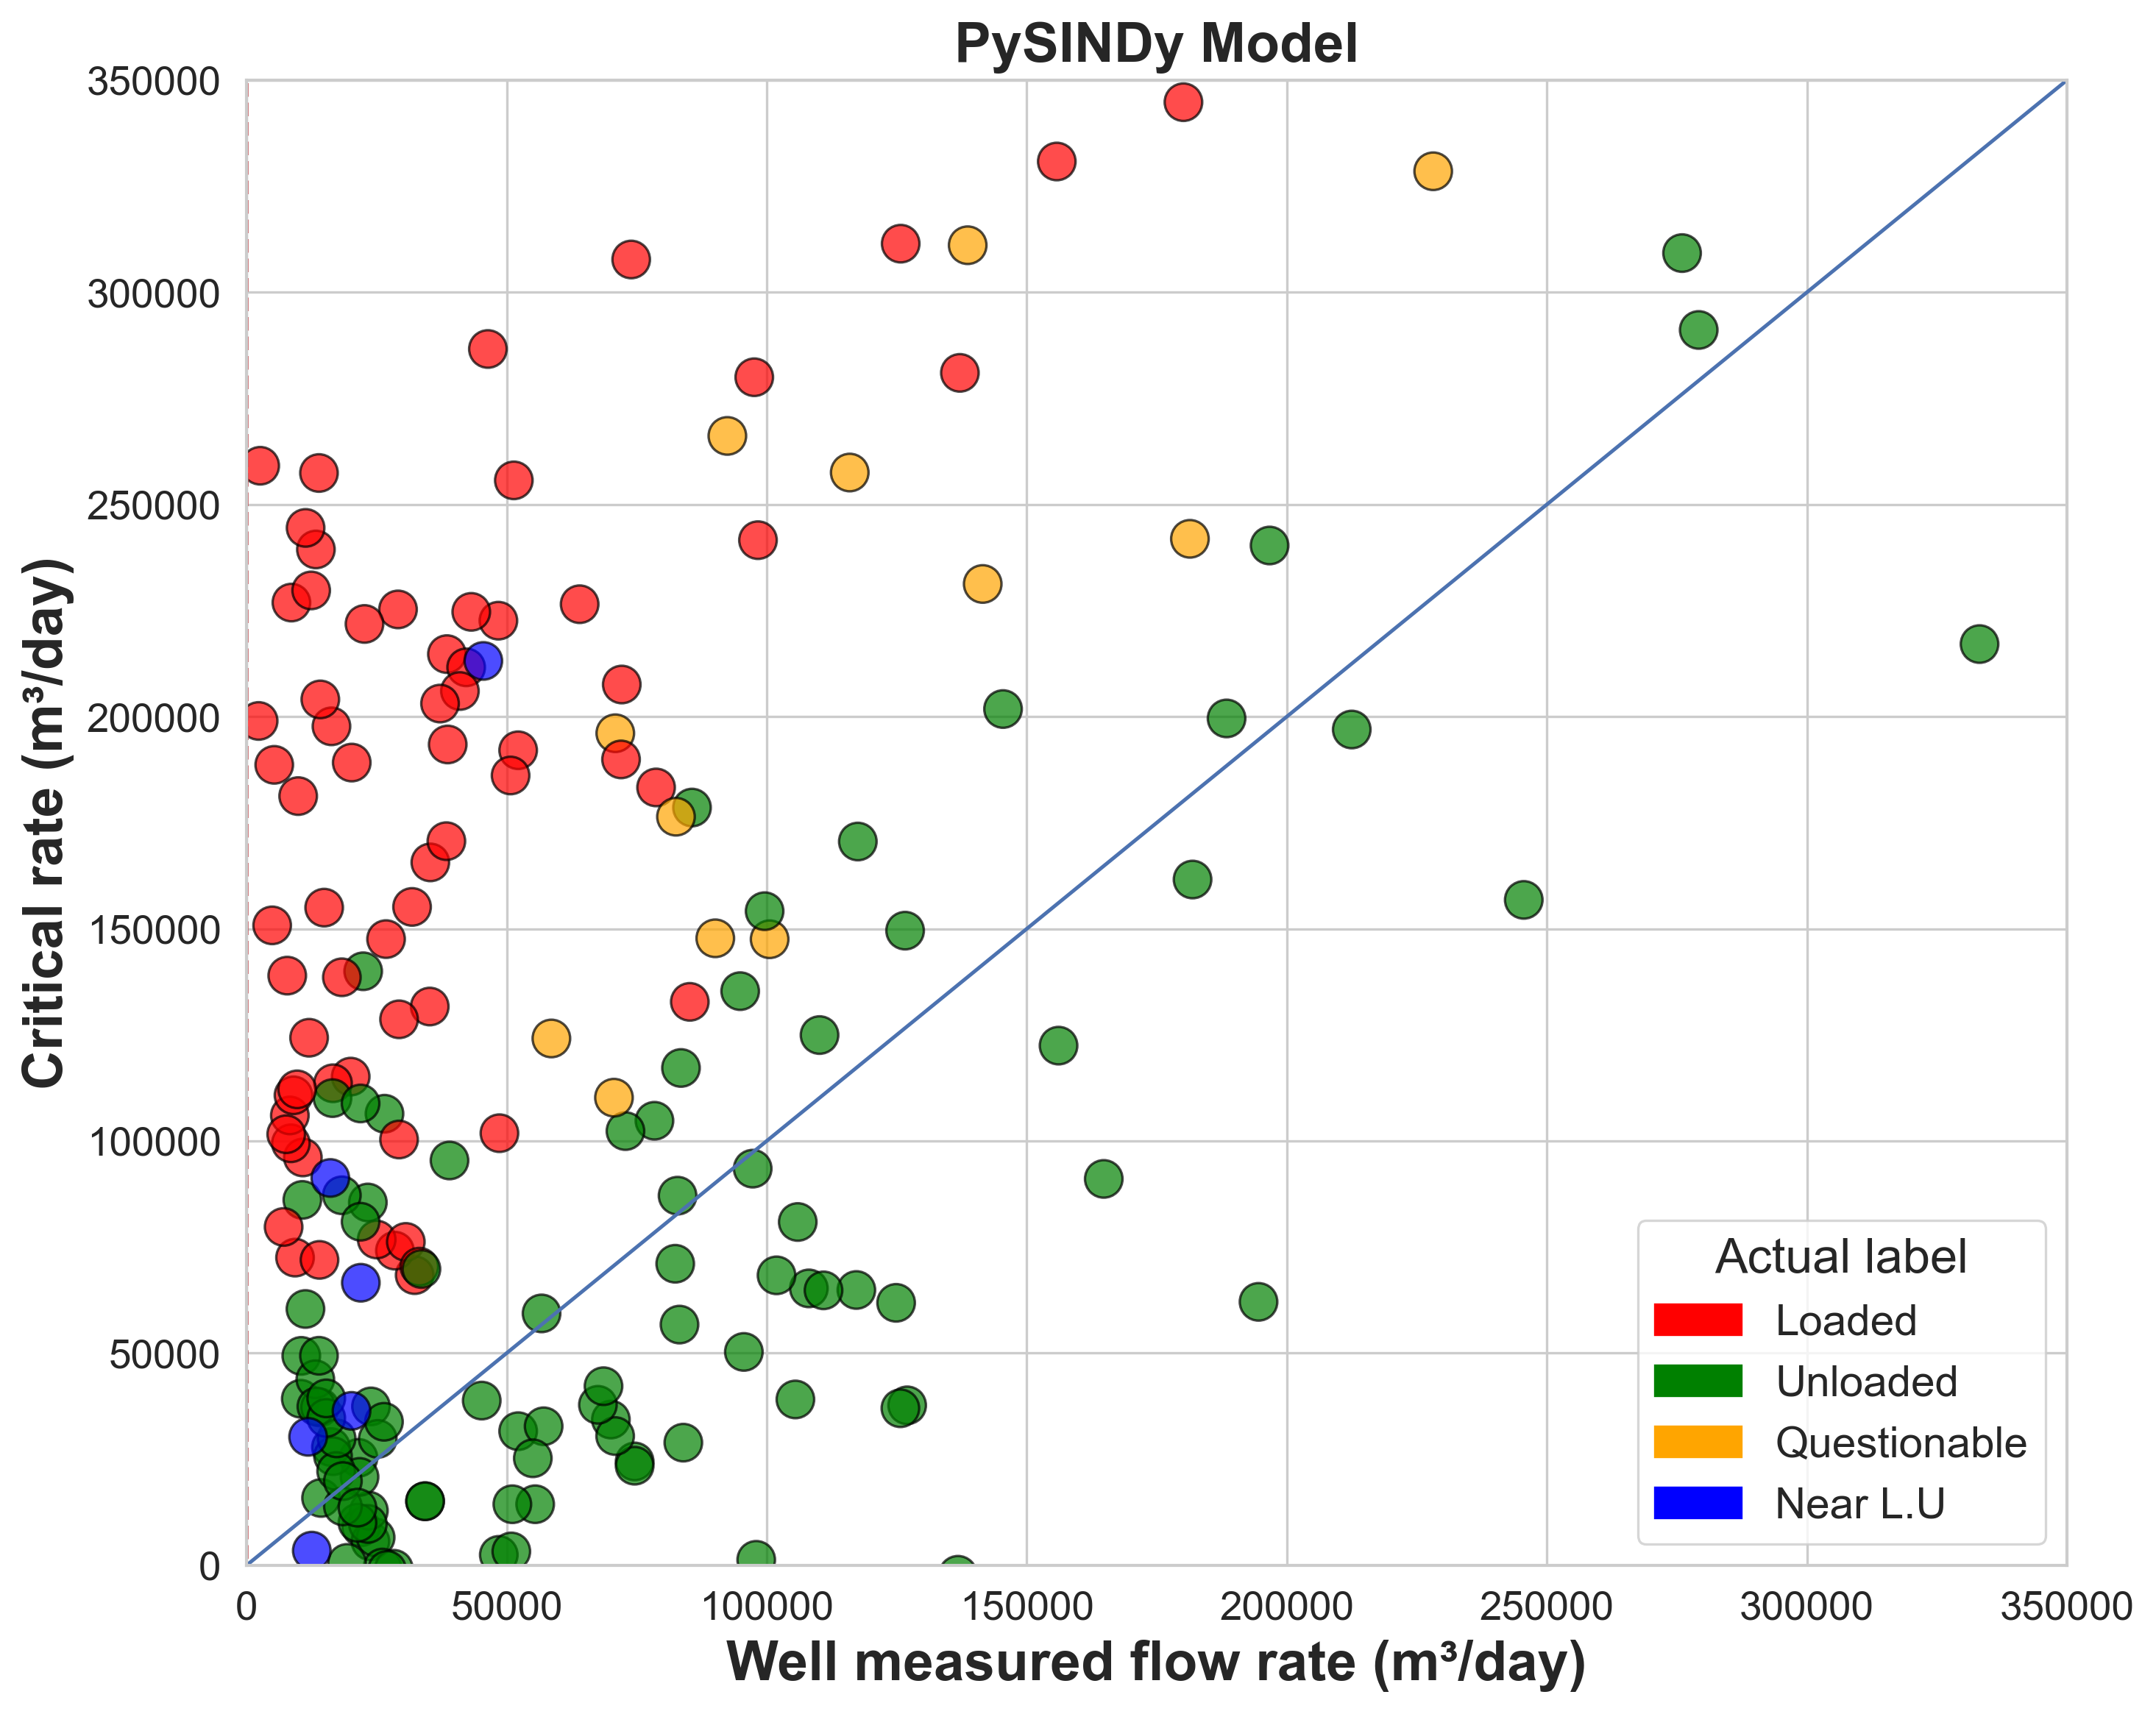

In [147]:
# Set a high-quality theme for publication
sns.set_theme(style="whitegrid", context="paper", font_scale=1.5)

# Define the color mapping for the "Test status"
color_map = {
    "Loaded": "red",
    "Unloaded": "green",
    "Questionable": "orange",
    "Near L.U": "blue"
}

# Evalute entire model performance
y_pred_scaled = final_model.predict(X_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

# Slice the first 40 entries for plotting.
gasflow_subset = gsflow
y_pred_subset = y_pred
colors_subset = df['Test status'].map(color_map).fillna("gray")

# Create a high-resolution figure.
plt.figure(figsize=(10, 8), dpi=300)
plt.scatter(gasflow_subset, y_pred_subset, c=colors_subset, alpha=0.7, s = 150, edgecolors="black", label="gplearn Predictions")

plt.plot([0, 350000], [0, 350000], [min(y_pred[:42]), max(y_pred[:42])], '--r')


# Set bold axis labels with increased font sizes.
plt.title("PySINDy Model", fontsize=18, fontweight='bold')
plt.xlabel("Well measured flow rate (m³/day)", fontsize=18, fontweight='bold')
plt.ylabel("Critical rate (m³/day)", fontsize=18, fontweight='bold')
plt.grid(True)
plt.xlim(0, 350000)
plt.ylim(0, 350000)

# Create legend patches from the color map.
legend_patches = [mpatches.Patch(color=color, label=status) for status, color in color_map.items()]
# legend_patches.append(mpatches.Patch(color="gray", label="Unknown"))
plt.legend(handles=legend_patches, title='Actual label', fontsize=14, title_fontsize=16)

plt.tight_layout()
plt.savefig("high_quality_scatter_gao.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# Fit model for literature comparsion

In [ ]:
# Split features
X = df[['Dia', 'Dev(deg)','Area (m2)', 'z','GasDens','LiquidDens', 'P/T','friction_factor', 'critical_film_thickness']]
y = df['Qcr']
gsflow = df['Gasflowrate']  # This is your additional target for classification metrics

# load class labels: loaded/unloaded/near loaded
loading_class = df['Test status'].apply(
    lambda x: -1 if x == 'Unloaded' else (0 if x == 'Near L.U' else 1)).to_numpy()

# Perform the train-test split, making sure to split all targets simultaneously
X_train, X_test, y_train, y_test, gsflow_train, gsflow_test, loading_train, loading_test = train_test_split(
    X, y, gsflow, loading_class, test_size=0.20, random_state=42, stratify=loading_class
)

"""
For final evaluation of the model, we need designate test data and normalize to all training data
"""
# Scale your features and continuous target (Qcr)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
X_scaled = scaler_X.transform(X)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))
y_scaled = scaler_y.transform(y.values.reshape(-1, 1))

# t_train is just an index array for plotting
t_train = np.arange(len(y_train_scaled))
t = np.arange(len(y_scaled))

#convert to a numpy array and store test data 
loading_train = np.array(loading_train)
loading_test = np.array(loading_test)
loading = np.array(loading_class)
gsflow_test = np.array(gsflow_test)
gsflow = np.array(gsflow)
y_test = np.array(y_test)
y = np.array(y)